# Transfer Learning with TensorFlow Part 1: Feature Extraction
Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.

2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# to check GPU
!nvidia-smi

Fri Feb 24 16:30:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Get data 
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-02-24 16:30:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.8MB/s    in 4.5s    

2023-02-24 16:30:26 (36.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger

# Creating data loaders (preparing the data)

In [4]:
# Setup data inputs
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen  = ImageDataGenerator(rescale = 1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training.  

In [5]:
# Create TensorBoard callback

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Creating models using TensorFlow Hub


In [6]:
# model url

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [7]:
# Imports
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# create model() function to create a model from a URL
def create_model(model_url, num_classes = 10):
  # Download the pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE + (3,))
  
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = "softmax", name = "output_layer")
  ])

  return model

In [9]:
# Creating and Testing ResNet Tensorflow Hub Feature Extraction model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
# Compile the resnet model 
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

# fit the model
history_resnet = resnet_model.fit(train_data_10_percent,
                 epochs = 5,
                 steps_per_epoch = len(train_data_10_percent),
                 validation_data = test_data,
                 validation_steps = len(test_data),
                 callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                         experiment_name = "resnet50v2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20230224-16301677256244
Epoch 1/5
24/24 [==============================] - 47s 1s/step - loss: 1.8552 - accuracy: 0.3880 - val_loss: 1.1767 - val_accuracy: 0.6268
Epoch 2/5
24/24 [==============================] - 17s 735ms/step - loss: 0.8871 - accuracy: 0.7547 - val_loss: 0.8499 - val_accuracy: 0.7276
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.6041 - accuracy: 0.8427 - val_loss: 0.7625 - val_accuracy: 0.7512
Epoch 4/5
24/24 [==============================] - 17s 740ms/step - loss: 0.4602 - accuracy: 0.8800 - val_loss: 0.7050 - val_accuracy: 0.7680
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.3830 - accuracy: 0.9133 - val_loss: 0.6995 - val_accuracy: 0.7628


In [11]:
# resnet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


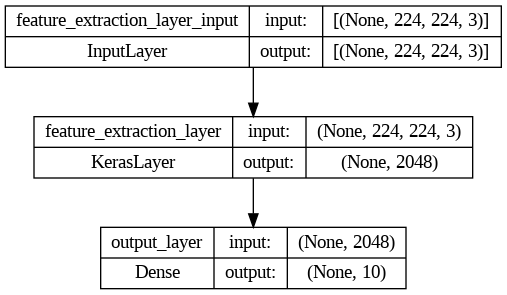

In [12]:
# plot model for resnet
tf.keras.utils.plot_model(resnet_model, show_shapes=True)

In [13]:
# creating and testing 
efficientnet_model = create_model(efficientnet_url,
                                  num_classes = train_data_10_percent.num_classes)

In [14]:
# compile the efficientnet model
efficientnet_model.compile(loss = "categorical_crossentropy",
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ["accuracy"])

# fit the model
history_efficientnet = efficientnet_model.fit(train_data_10_percent,
                                             epochs = 5,
                                             steps_per_epoch = len(train_data_10_percent),
                                             validation_data = test_data,
                                             validation_steps = len(test_data),
                                             callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                                      experiment_name = "efficientnet")])

Saving TensorBoard log files to: tensorflow_hub/efficientnet/20230224-16331677256408
Epoch 1/5
24/24 [==============================] - 37s 993ms/step - loss: 1.8342 - accuracy: 0.4280 - val_loss: 1.2916 - val_accuracy: 0.7380
Epoch 2/5
24/24 [==============================] - 19s 829ms/step - loss: 1.0427 - accuracy: 0.7867 - val_loss: 0.8643 - val_accuracy: 0.8192
Epoch 3/5
24/24 [==============================] - 20s 844ms/step - loss: 0.7552 - accuracy: 0.8200 - val_loss: 0.6980 - val_accuracy: 0.8420
Epoch 4/5
24/24 [==============================] - 23s 972ms/step - loss: 0.6064 - accuracy: 0.8587 - val_loss: 0.6155 - val_accuracy: 0.8480
Epoch 5/5
24/24 [==============================] - 18s 768ms/step - loss: 0.5153 - accuracy: 0.8840 - val_loss: 0.5599 - val_accuracy: 0.8612


In [15]:
# efficientnet summary()
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


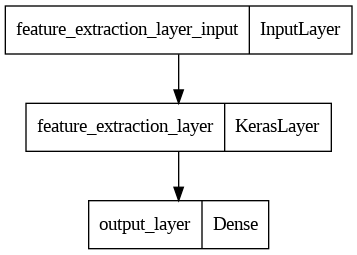

In [16]:
# plot model for efficientnet model
tf.keras.utils.plot_model(efficientnet_model) 

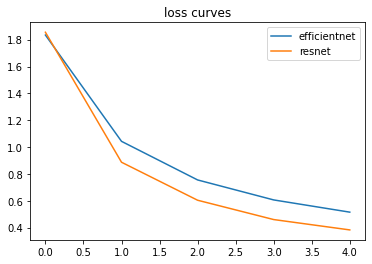

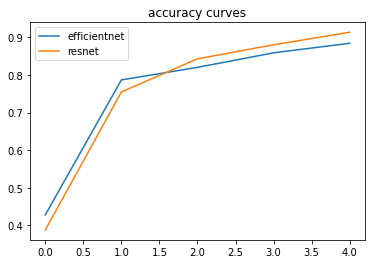

In [17]:
# plotting loss and accuracy curves for both models
import matplotlib.pyplot as plt

efficientnet_loss = history_efficientnet.history["loss"]
efficientnet_accuracy = history_efficientnet.history["accuracy"]

resnet_loss = history_resnet.history["loss"]
resnet_accuracy = history_resnet.history["accuracy"]

plt.plot(efficientnet_loss, label = "efficientnet")
plt.plot(resnet_loss, label = "resnet")
plt.legend()
plt.title("loss curves");

plt.figure()
plt.plot(efficientnet_accuracy,label = "efficientnet")
plt.plot(resnet_accuracy, label = "resnet")
plt.legend()
plt.title("accuracy curves");

In [18]:
# to find the no of layers in efficientnet layer
len(efficientnet_model.layers[0].weights)

309

# Different types of transfer learning

1. **"As in" transfer learning** - using an existing model with no changes what so ever 
2. **"Feature extraction** - use the prelearned patterns of an existing model and adjust the output layer for your own problem
3. **"Fine-tuning"** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers

# Comparing our models results using tensorboard

In [19]:
# # upload tensorboard dev records
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
# --name "Efficient vs Resnet" \
# --description "Comparing two different transfer learning model" \
# --one_shot

# Building with full data

In [25]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

--2023-02-24 16:38:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 172.217.218.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.3’

10_food_classes_all 100%[===================>] 495.13M  42.1MB/s    in 12s     

2023-02-24 16:38:59 (40.9 MB/s) - ‘10_food_classes_all_data.zip.3’ saved [519183241/519183241]



In [32]:
trainfuldata_dir = "/content/10_food_classes_all_data/train"
trainfuldatagen = ImageDataGenerator(rescale = 1/255.)
trainfuldata = trainfuldatagen.flow_from_directory(trainfuldata_dir,
                                                     target_size = (224, 224),
                                                     batch_size = 32,
                                                     class_mode = "categorical")

Found 7500 images belonging to 10 classes.


In [33]:
efficientnet_fulldatamodel = create_model(efficientnet_url, trainfuldata.num_classes)

In [38]:
efficientnet_fulldatamodel.compile(loss = "categorical_crossentropy",
                                   optimizer = tf.keras.optimizers.Adam(),
                                   metrics = ["accuracy"])
efficientnet_fulldatamodel.fit(trainfuldata,
                               epochs = 50,
                               steps_per_epoch = len(trainfuldata),
                               validation_data = test_data,
                               validation_steps = len(test_data),
                               callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hum",
                                                                        experiment_name = "efficientnet_fulldata"),tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 3,start_from_epoch = 5)])

Saving TensorBoard log files to: tensorflow_hum/efficientnet_fulldata/20230224-17021677258164
Epoch 1/50
235/235 [==============================] - 58s 226ms/step - loss: 0.1655 - accuracy: 0.9545 - val_loss: 0.2588 - val_accuracy: 0.9188
Epoch 2/50
235/235 [==============================] - 50s 211ms/step - loss: 0.1500 - accuracy: 0.9632 - val_loss: 0.2594 - val_accuracy: 0.9152
Epoch 3/50
235/235 [==============================] - 50s 211ms/step - loss: 0.1422 - accuracy: 0.9625 - val_loss: 0.2595 - val_accuracy: 0.9188
Epoch 4/50
235/235 [==============================] - 50s 213ms/step - loss: 0.1322 - accuracy: 0.9671 - val_loss: 0.2653 - val_accuracy: 0.9156
Epoch 5/50
235/235 [==============================] - 50s 214ms/step - loss: 0.1241 - accuracy: 0.9727 - val_loss: 0.2631 - val_accuracy: 0.9172
Epoch 6/50
235/235 [==============================] - 51s 216ms/step - loss: 0.1172 - accuracy: 0.9741 - val_loss: 0.2647 - val_accuracy: 0.9164
Epoch 7/50
235/235 [================